In [20]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
import folium
import matplotlib.pyplot as plt


In [23]:
# Define the paths to the folders containing the images
healthy_folder = '/content/pepper_bell_healthy'  # Adjust the path if necessary
bacterial_spot_folder = '/content/Pepper__bell___Bacterial_spot'  # Adjust the path if necessary

# Set image size for uniformity
img_size = (150, 150)

# Initialize lists to store image data and labels
images = []
labels = []

# Function to load and preprocess images
def load_images_from_folder(folder, label):
    for file_name in os.listdir(folder):
        if file_name.endswith('.JPG') or file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            img = load_img(img_path, target_size=img_size)  # Resize image
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)

# Load images from both folders
load_images_from_folder(healthy_folder, label=0)  # 0 for healthy
load_images_from_folder(bacterial_spot_folder, label=1)  # 1 for bacterial spot

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images from two classes: Healthy and Bacterial Spot.")


Loaded 2474 images from two classes: Healthy and Bacterial Spot.


In [24]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (1979, 150, 150, 3)
Testing data shape: (495, 150, 150, 3)


In [25]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 786ms/step - accuracy: 0.6950 - loss: 0.5923 - val_accuracy: 0.9414 - val_loss: 0.1626
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 139s 765ms/step - accuracy: 0.9068 - loss: 0.2671 - val_accuracy: 0.9434 - val_loss: 0.1717
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 92s 745ms/step - accuracy: 0.9466 - loss: 0.1579 - val_accuracy: 0.9758 - val_loss: 0.0563
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 801ms/step - accuracy: 0.9753 - loss: 0.0726 - val_accuracy: 0.9657 - val_loss: 0.0803
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 92s 747ms/step - accuracy: 0.9757 - loss: 0.0806 - val_accuracy: 0.9879 - val_loss: 0.0288
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 94s 758ms/step - accuracy: 0.9772 - loss: 0.0618 - val_accuracy: 0.9980 - val_loss: 0.0174
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 0.9868 - loss: 0.0424 - val_accuracy: 0.9960 - val_loss: 0.0158
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 92s 740ms/step - accuracy: 0.9911 - los

In [26]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.9994 - loss: 0.0036
Test accuracy: 0.9979798197746277


In [27]:
# Save the trained model
model.save('/content/pepper_crop_health_model.h5')
print("Model saved as 'pepper_crop_health_model.h5'.")


Model saved as 'pepper_crop_health_model.h5'.


In [28]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/content/pepper_crop_health_model.h5')

# Function to predict the health status of a crop image
def predict_health(image_path, model):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class (0: Healthy, 1: Bacterial Spot)
    prediction = model.predict(img_array)
    return "Healthy" if prediction[0][0] < 0.5 else "Bacterial Spot"

# Test the prediction on a new image
test_image_path = '/content/sample_img.jpeg'  # Replace with the path to your test image
health_status = predict_health(test_image_path, loaded_model)
print(f"The predicted health status is: {health_status}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
The predicted health status is: Healthy


In [29]:
# Example: Define coordinates for the crop location (latitude, longitude)
coordinates = [40.7128, -74.0060]  # Replace with actual coordinates of the crop location (New York as example)

# Create a Folium map centered at the crop location
map = folium.Map(location=coordinates, zoom_start=10)

# Add a marker for the crop health status
folium.Marker(
    location=coordinates,
    popup=f"Crop Health: {health_status}",
    icon=folium.Icon(color="green" if health_status == "Healthy" else "red")
).add_to(map)

# Save the map as an HTML file
map.save("/content/crop_health_map.html")
print("Map saved as 'crop_health_map.html'.")


Map saved as 'crop_health_map.html'.


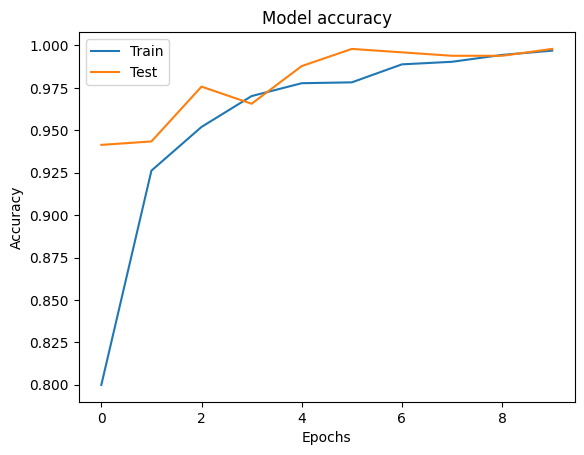

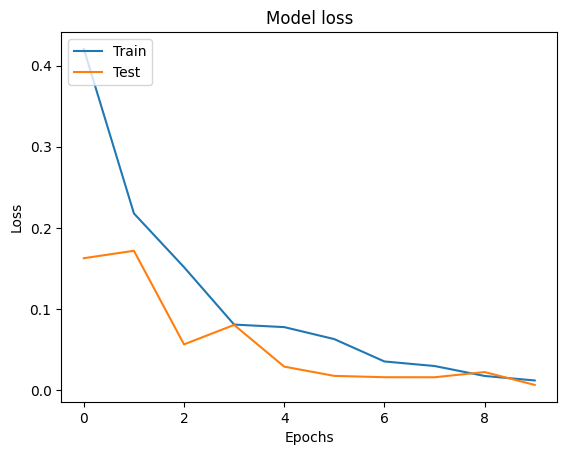

In [30]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
